# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
# from environment import CacheEnv
from e2 import CacheEnv
# from environment import scheduler
%load_ext autoreload
%autoreload 2

In [2]:
# x = np.random.rand(20)
# x /= x.sum()
# x

In [3]:
# env vars
EPS_LEN = 100
N_PAGES = 20
CACHE_LIMIT = 10 
env = CacheEnv(
        eps_len=EPS_LEN, 
        n_pages=N_PAGES, 
        limit=CACHE_LIMIT
        )

# dqn vars
N_EPS = 60000
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 2000   # target update frequency
MEMORY_CAPACITY = 20000

s = env.reset()
N_ACTIONS = env.action_space_n
STATE_SHAPE = (CACHE_LIMIT, 2)
N_STATES = STATE_SHAPE[0]*STATE_SHAPE[1]

Cache limit: 10
Total Pages: 20


In [7]:
print(N_ACTIONS)
print(N_STATES)

10
20


In [44]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        input_size = N_STATES
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 10)
#         self.fc3 = nn.Linear(10, 100)
        self.out = nn.Linear(10, N_ACTIONS)

    def forward(self, x):
#         bs = x.shape[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
        x = self.out(x)
        return F.softmax(x)

In [47]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net().cuda(), Net().cuda()
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.NLLLoss()
        self.PATH = 'model/'

    def choose_action(self, x):
#         print(f"X for choose action: {x}")
        x = torch.unsqueeze(torch.FloatTensor(x), 0).cuda()
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net(x).detach().cpu()
            action = torch.argmax(actions_value).cpu().data.numpy()
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES]).cuda()
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:]).cuda()

        # q_eval w.r.t the action in experience
        out = self.eval_net(b_s).cpu()
#         print(out.shape)
#         print("b_a:", b_a.shape)
#         print("b_a:", b_a.max(), '\t', b_a.min())
        q_eval = out.gather(1, b_a)  # shape (batch, 1) (
        q_next = self.target_net(b_s_).detach().cpu()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save_model(self, eval_name = 'eval_net', train_name = 'train_net'):
        torch.save(self.eval_net.state_dict(), self.PATH  + str(N_STATES) + eval_name)
        torch.save(self.target_net.state_dict(), self.PATH  + str(N_STATES)+ train_name)
        
    def load_model(self, eval_name = 'eval_net.m', train_name = 'train_net.m'):
        self.eval_net.load_state_dict(torch.load(self.PATH +  str(N_STATES) + eval_name))
        self.target_net.load_state_dict(torch.load(self.PATH  + str(N_STATES) + train_name))

In [48]:
start = time.time()
dqn = DQN()
# dqn.load_model()
print("Start")
print('\nCollecting experience...')
history = []
for i_episode in range(N_EPS):
    s = env.reset()
    ep_r = 0
    n = 0
    while True:
        a = dqn.choose_action(s)
        s_, r, done, info = env.step(a)
        dqn.store_transition(s, a, r, s_)
        ep_r += r
        n += 1
        
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
        
        if done:
            history.append(ep_r)
            if (dqn.memory_counter > MEMORY_CAPACITY) and i_episode%100==0:
                print('Ep: ', i_episode, '| Ep_r: ', ep_r, 'Ran for:', n)
            break

        s = s_
end = time.time()

Start



/home/timetraveller/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

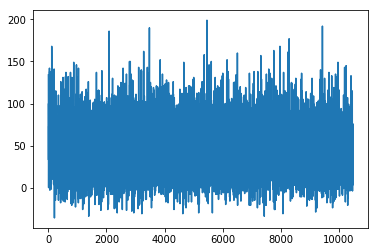

In [10]:
import matplotlib.pyplot as plt
plt.plot(history)
plt.show()

In [45]:
# s = env.reset()
a = 2
s, r, done, info = env.step(a)
print(s)
state = torch.Tensor(s).cuda()
print(dqn.target_net(state))

[11 13 41  6  8  6 12  8 17  3  5  3 13  7  3 10  4  9  1  7]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


/home/timetraveller/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [46]:
net = Net().cuda()
print(net(state))

tensor([0.0181, 0.0309, 0.0882, 0.0604, 0.0591, 0.0954, 0.2653, 0.1259, 0.1774,
        0.0794], device='cuda:0', grad_fn=<SoftmaxBackward>)


/home/timetraveller/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
